# Segmentação de perfis

Nesse notebook vou analisar a base *studentInfo* com o objetivo de encontrar agrupamentos inerentes aos dados. Vamos partir de uma abordagem não supervisionada.

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from missingno import matrix

mpl.rcParams['figure.dpi'] = 200
sns.set_style("darkgrid")

In [4]:
studentInfo = pd.read_csv("../../data/raw/studentInfo.csv")
studentInfo

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn


## Pré processamento

Como o *dataset* contêm variáveis categoricas, estas vão ser codificadas no padrão one-hot. Após isso vamos transformar sua distribuição em uma normal padrão.

In [151]:
from sklearn.preprocessing import OneHotEncoder

X = studentModuleData.drop(columns=['code_module', 'code_presentation', 'region'])#.set_index('id_student')

X.imd_band.fillna('None', inplace=True)

categorical = X.dtypes.map(lambda x: x == 'object')
categorical_features = X.columns[categorical]
    
encoders = {}
for cat in categorical_features:
    enc = OneHotEncoder()
    encoded = enc.fit_transform(X[cat].values.reshape(-1, 1)).toarray()
    encoders[cat] = enc
    
    df = pd.DataFrame(
        encoded,
        columns=[f"{cat}_{c}" for c in enc.categories_[0]]
    )
    X = pd.concat([X.drop(columns=[cat]), df], axis=1)
    
X = X.drop(columns=["id_student"])
X

,num_of_prev_attempts,studied_credits,gender_F,gender_M,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,imd_band_0-10%,...,imd_band_None,age_band_0-35,age_band_35-55,age_band_55<=,disability_N,disability_Y,final_result_Distinction,final_result_Fail,final_result_Pass,final_result_Withdrawn
0,0,240,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0,60,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0,60,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0,60,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,60,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,0,30,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
32589,0,30,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
32590,0,30,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
32591,0,30,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [152]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_norm = ss.fit_transform(X)

## Redução de dimensionalidade - Para visualização 

Utilizamos o algorítmo de TSNE para gerar um espaço de baixa dimensionalidade onde possamos observar o resultado da clusterização.

In [160]:
from sklearn.manifold import TSNE

X_embedded = TSNE(
    n_components=2, 
    n_jobs=-1
).fit_transform(X_norm)
X_embedded.shape

(32593, 2)

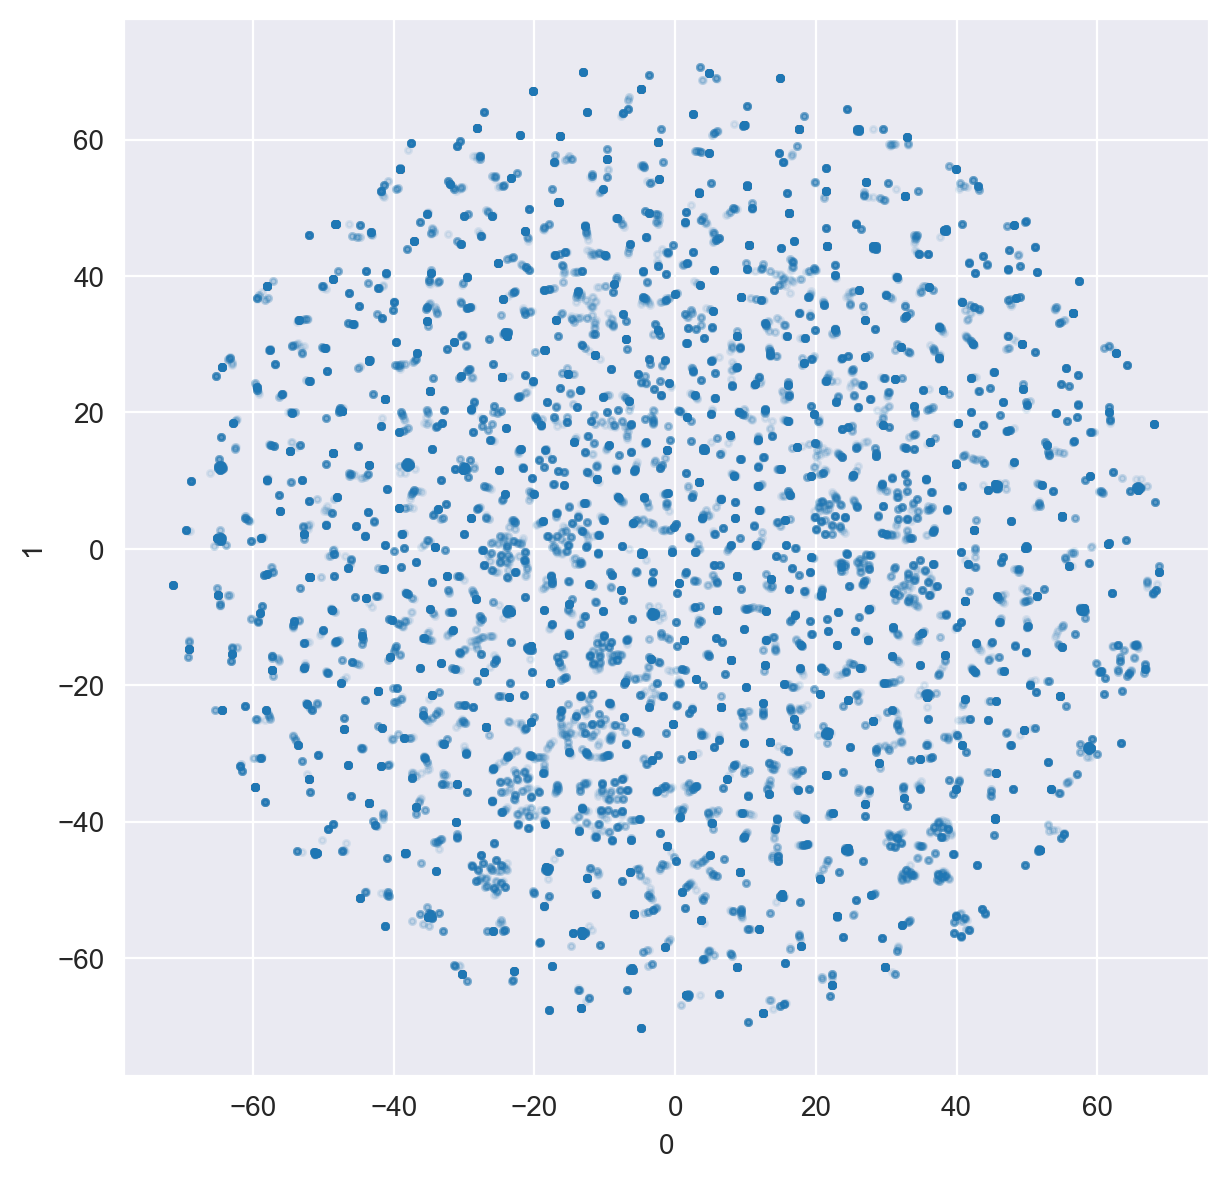

In [180]:
tsne_components = pd.DataFrame(X_embedded)
_, ax = plt.subplots(1, 1, figsize=(1, 1))
tsne_components.plot.scatter(0, 1, figsize=(7, 7), alpha=0.1, s=5, ax=ax);

## Determinando o número ótimo de grupos

Utilizando o *elbow-method*, foi determinado que o número ótimo de grupos é 15, pois este é o valor que coincide com o cotovelo no gráfico da inercia dos grupos em função da quantidade de grupos escolhida.

49


'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.


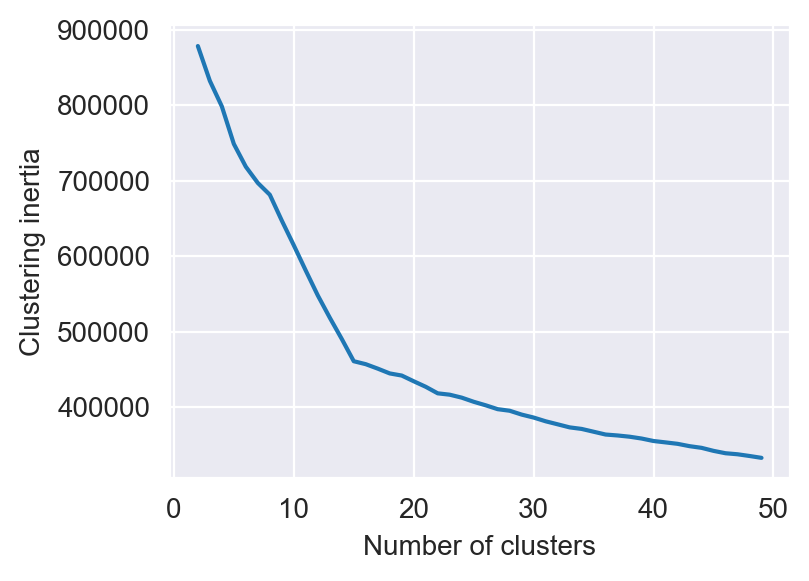

In [146]:
from sklearn.cluster import KMeans
from IPython.display import clear_output

inertia = []
n_clusters = list(range(2,50))

for k in n_clusters:
    clear_output(wait=True)
    print(k)
    km = KMeans(n_clusters=k, random_state=42, n_jobs=-1)
    km.fit(X_norm)
    inertia.append(km.inertia_)

plt.figure(figsize=(4, 3)) 
plt.plot(n_clusters, inertia)
plt.xlabel("Number of clusters")
plt.ylabel("Clustering inertia")
plt.show();

## Clusterização

Aplicamos o algorítmo K-Means com o número de clusters obtidos na sessão anterior.

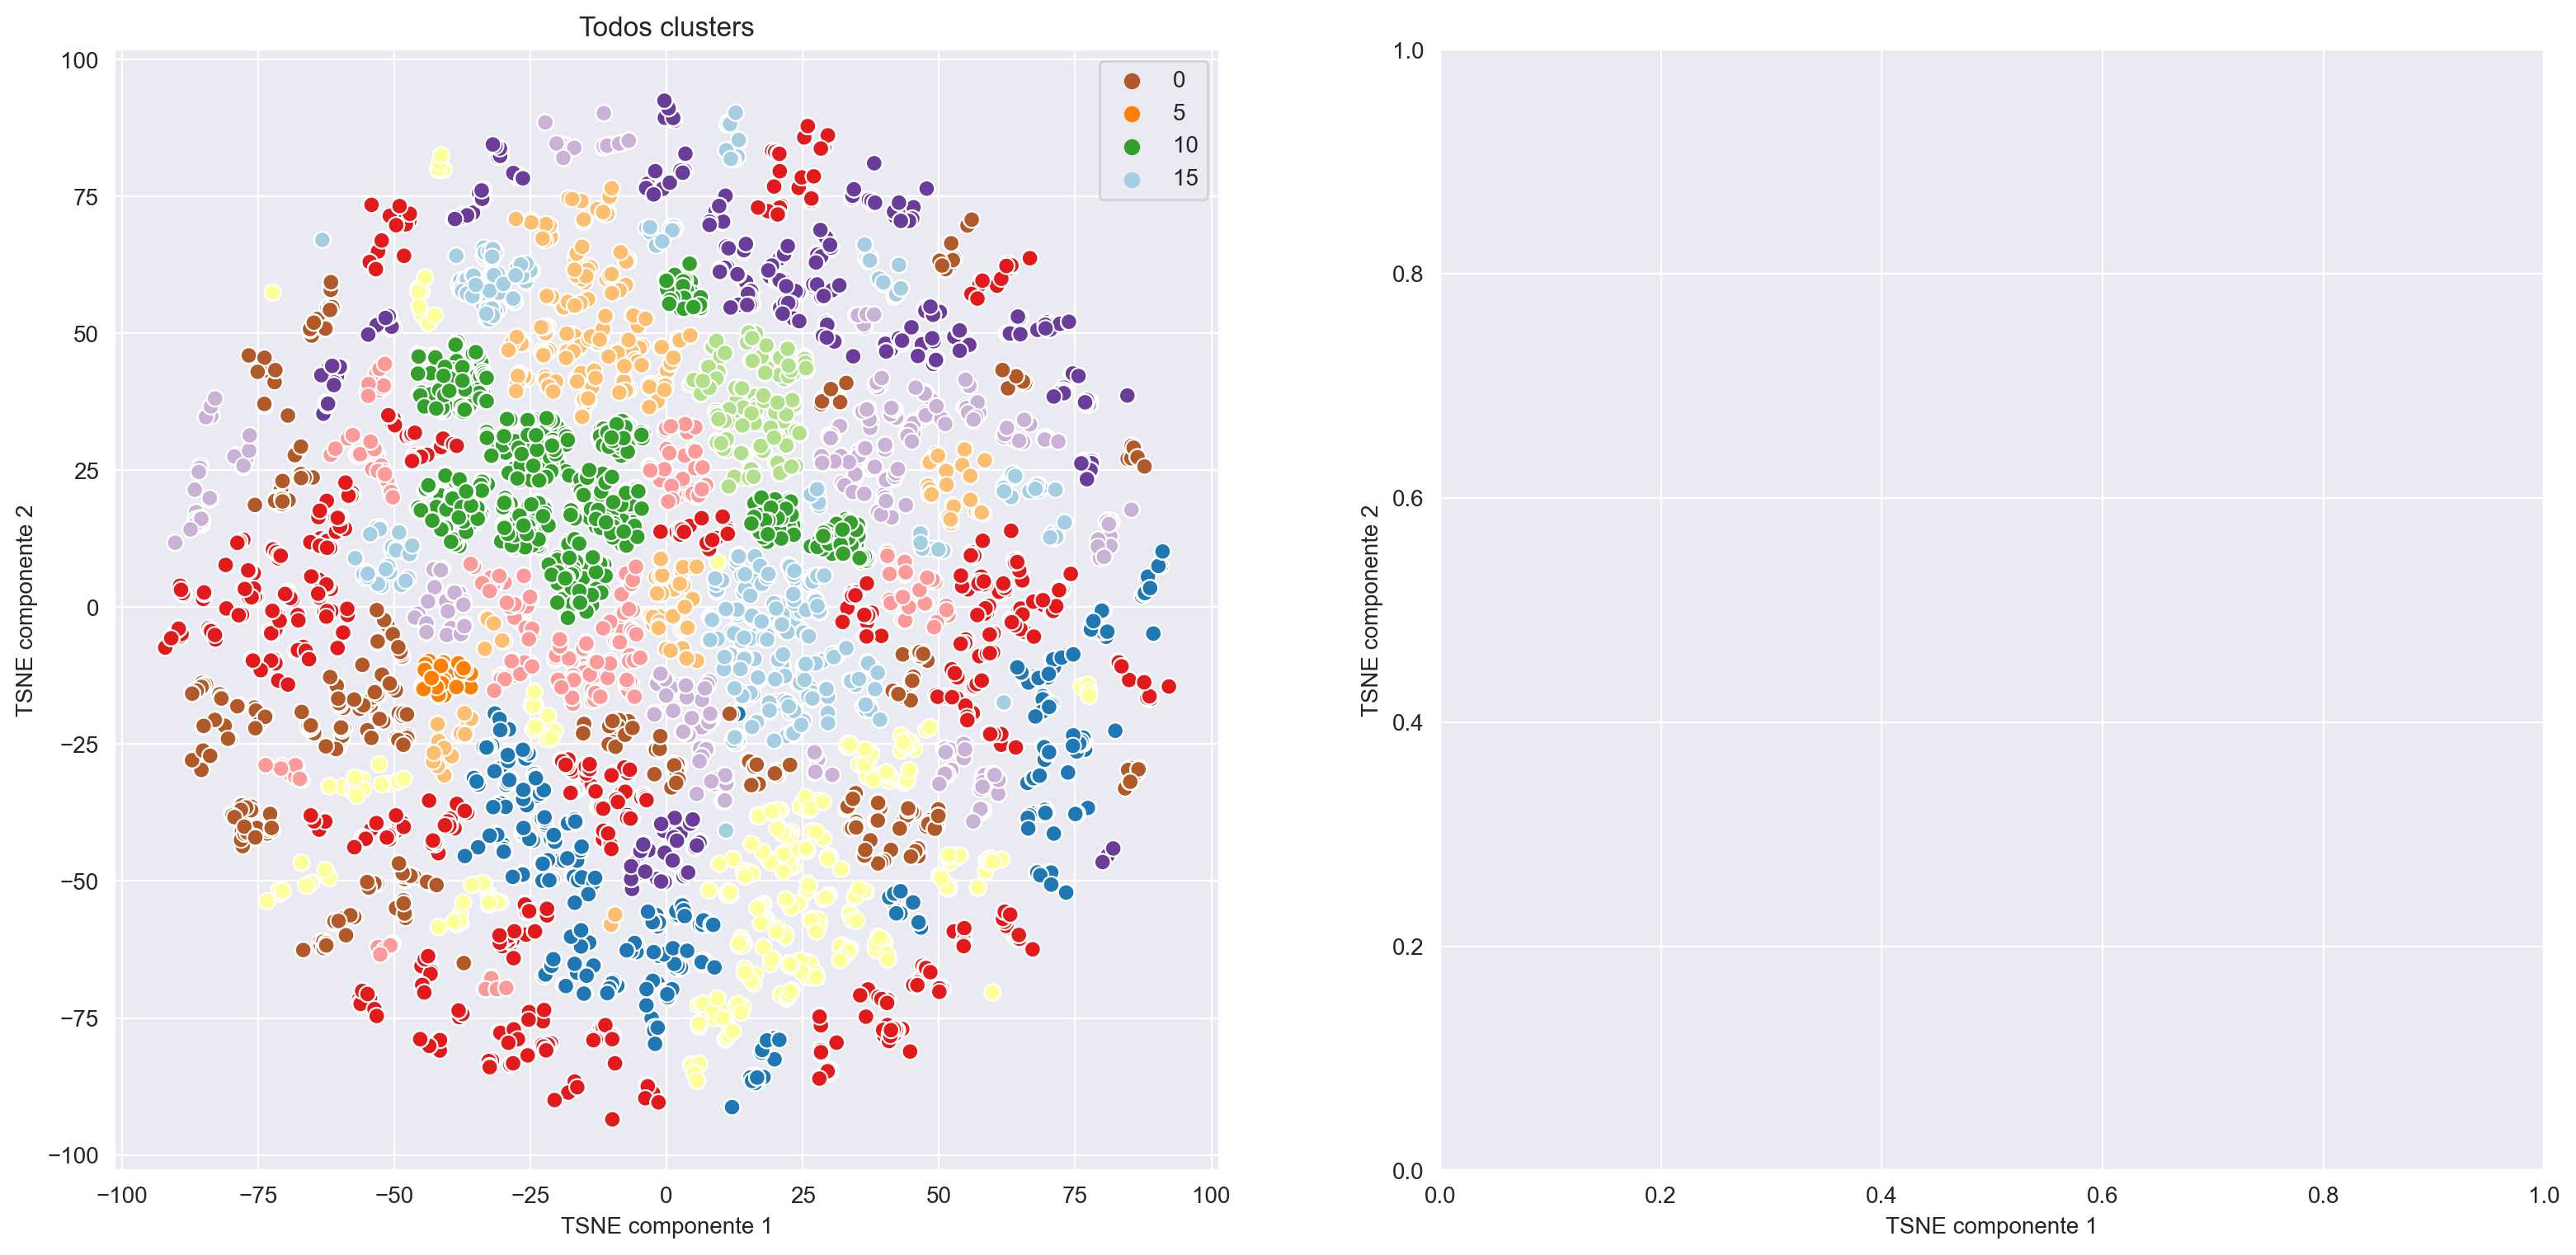

In [167]:
km = KMeans(n_clusters=15, random_state=42)
Y = km.fit_predict(X_norm)

n_clusters = np.unique(Y).size
_, ax = plt.subplots(1, 2, figsize=(19, 9))

sns.scatterplot(
    tsne_components[0], 
    tsne_components[1], 
    hue=Y,
    palette='Paired_r',
    alpha=1,
    s=50,
    ax=ax[0]
)

ax[0].set_title("Todos clusters")
ax[0].legend()

for a in ax:
    a.set_ylabel("TSNE componente 2")
    a.set_xlabel("TSNE componente 1")


## Criando modelo explicativo da clusterização

In [171]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size=0.33, random_state=42, stratify=Y)

clf = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)

## Avaliação e interpretação

Aqui utilizamos a matriz de confusão para avaliar os resultados do modelo.

Observamos também o valor de seus coeficientes para determinar a importância relativa de cada uma das variáveis.

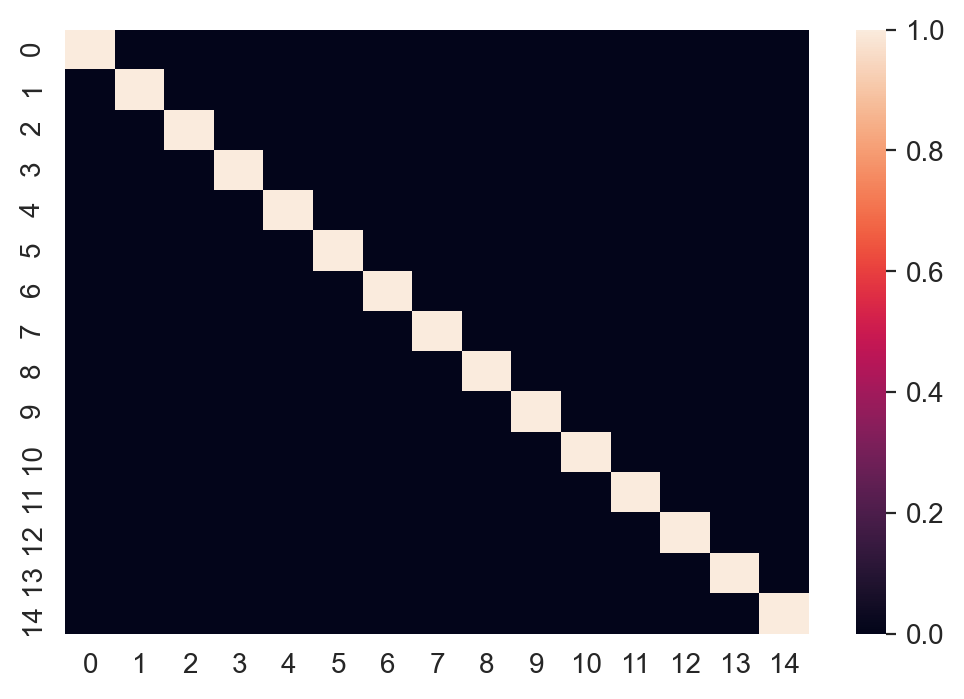

In [178]:
from sklearn.metrics import confusion_matrix

y_pred_test = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)

for line in range(len(cm)):
    cm[line] = cm[line] / sum(y_test == line)

sns.heatmap(cm);

In [179]:
all(y_test == y_pred_test)

True

In [172]:

for group in np.unique(Y):
    print(f"\n\nGroup {group}")
    coefs = {col: coef[group] for col, coef in zip(X.columns, clf.coef_)}
    dt = sorted(coefs.items(), key=lambda x: x[1], reverse=True)
    print("\npositive")
    for k, v in dt[:3]:
        print(k, v)
    print("\nnegative")
    for k, v in dt[-3:]:
        print(k, v)



Group 0

positive
imd_band_10-20 0.043730042991435465
num_of_prev_attempts 0.019868925972530538
imd_band_50-60% 0.014928313982069032

negative
studied_credits -0.017878998771185324
imd_band_20-30% -0.018228875086361417
imd_band_0-10% -0.020460144235541686


Group 1

positive
imd_band_10-20 0.05748831281207033
highest_education_Post Graduate Qualification 0.027549427653363184
studied_credits 0.017564601746190157

negative
num_of_prev_attempts -0.01746760467732488
highest_education_A Level or Equivalent -0.024095103961821115
gender_M -0.029813951598249934


Group 2

positive
imd_band_50-60% 0.05965100670589572
imd_band_10-20 0.037608667435619934
highest_education_Post Graduate Qualification 0.029179844099673155

negative
imd_band_0-10% -0.029401911907037764
highest_education_HE Qualification -0.056270038310742426
imd_band_20-30% -0.0619901369507528


Group 3

positive
imd_band_20-30% 0.061990136950752756
highest_education_HE Qualification 0.05627003831074241
imd_band_0-10% 0.0294019119